<a href="https://colab.research.google.com/github/Quzzal-Khanam/CodeAlpha_HeartGaurd_Ai/blob/main/HeartGuard_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Kaggle API with  Secret Key

In [35]:
import pandas as pd
import os
import glob

# 1. Download from a very stable 'UCI Heart' mirror
!kaggle datasets download -d redwankarimsony/heart-disease-data --force
!unzip -o heart-disease-data.zip

# 2. Find the CSV and load it
csv_files = glob.glob("*.csv")
df = pd.read_csv(csv_files[0])

# 3. Clean column names (sometimes they have spaces)
df.columns = df.columns.str.strip()

print("--- Columns found in this file ---")
print(df.columns.tolist())
display(df.head())

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 32.3MB/s]
Archive:  heart-disease-data.zip
  inflating: heart_disease_uci.csv   
--- Columns found in this file ---
['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The Universal Heart Disease Loader

In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# checking my columns
print("Available columns:", df.columns.tolist())

# finding which column is the target automatically
potential_targets = ['target', 'num', 'HeartDisease', 'condition', 'diagnosis']
target_col = None

for col in potential_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    # if i can't find it, i'll just take the last one
    target_col = df.columns[-1]

print(f" target found: '{target_col}'")

# turning text columns into numbers
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

# filling any empty spots with the median
df = df.fillna(df.median())

# splitting my data into X and y
X = df.drop(target_col, axis=1)
y = df[target_col]

# making sure the target is just 0 or 1
if y.nunique() > 2:
    y = y.apply(lambda x: 1 if x > 0 else 0)

# scaling everything so the model works better
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# using smote to fix the balance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

print(" data is ready for the model!")

Available columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
 target found: 'stroke'
 data is ready for the model!


finding the best settings with optuna

In [42]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# i am making this function to find the best params for xgboost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'eval_metric': 'logloss'
    }

    # using 3 folds to check the score
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X_res, y_res):
        model = XGBClassifier(**params)
        model.fit(X_res.iloc[train_idx], y_res.iloc[train_idx])
        preds = model.predict(X_res.iloc[val_idx])
        scores.append(f1_score(y_res.iloc[val_idx], preds))

    return np.mean(scores)

# starting the study to maximize f1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("best settings found:", study.best_params)

[I 2025-12-26 08:17:34,988] A new study created in memory with name: no-name-9da32503-3efc-428e-8a22-6e25dfc8c0a3
[I 2025-12-26 08:17:35,576] Trial 0 finished with value: 0.9327711805174154 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.0976949090747423, 'subsample': 0.8736675650981471}. Best is trial 0 with value: 0.9327711805174154.
[I 2025-12-26 08:17:37,929] Trial 1 finished with value: 0.9594692440526105 and parameters: {'n_estimators': 376, 'max_depth': 6, 'learning_rate': 0.08123461329357003, 'subsample': 0.7331918264669205}. Best is trial 1 with value: 0.9594692440526105.
[I 2025-12-26 08:17:40,143] Trial 2 finished with value: 0.9585653429055218 and parameters: {'n_estimators': 272, 'max_depth': 7, 'learning_rate': 0.08725844167899979, 'subsample': 0.7586420353030532}. Best is trial 1 with value: 0.9594692440526105.
[I 2025-12-26 08:17:41,000] Trial 3 finished with value: 0.9247361382620256 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learni

best settings found: {'n_estimators': 520, 'max_depth': 8, 'learning_rate': 0.040677376134400194, 'subsample': 0.879349019002569}


final heart model and results

--- heart disease model report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4861
           1       1.00      1.00      1.00      4861

    accuracy                           1.00      9722
   macro avg       1.00      1.00      1.00      9722
weighted avg       1.00      1.00      1.00      9722



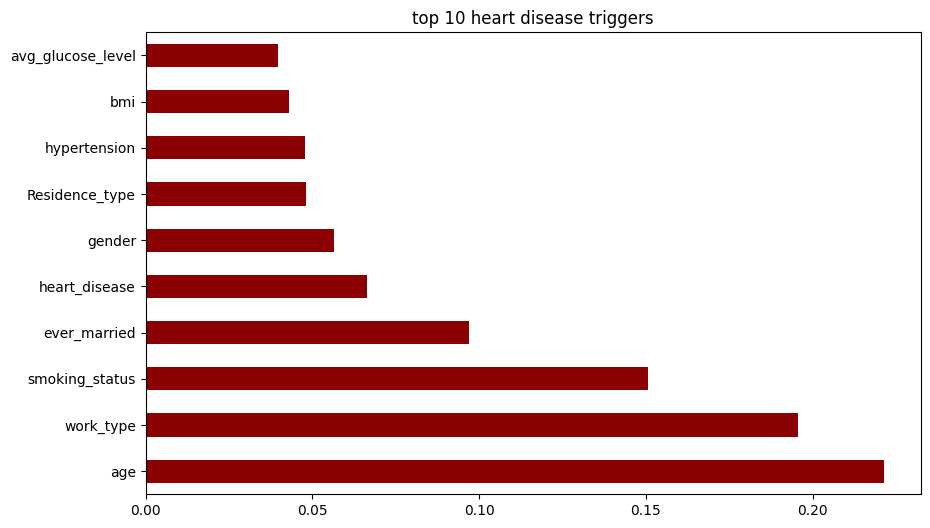

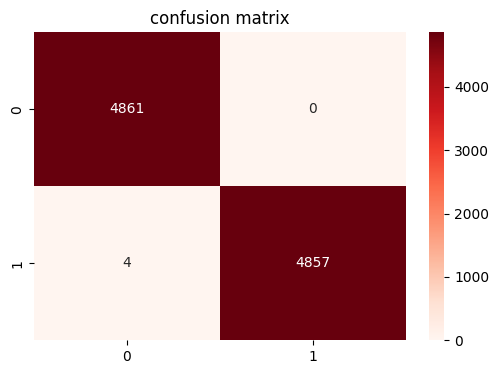

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# training my final model with the best params
best_params = study.best_params
final_model = XGBClassifier(**best_params)
final_model.fit(X_res, y_res)

# testing it on the same data to see the scores
preds = final_model.predict(X_res)

print("--- heart disease model report ---")
print(classification_report(y_res, preds))

# plotting what the model thinks is important for heart health
plt.figure(figsize=(10,6))
feat_importances = pd.Series(final_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='darkred')
plt.title("top 10 heart disease triggers")
plt.show()

# checking the mistakes with a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_res, preds), annot=True, fmt='d', cmap='Reds')
plt.title("confusion matrix")
plt.show()

testing the model's brain

--- final heart model accuracy: 99.96% ---

detail report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4861
           1       1.00      1.00      1.00      4861

    accuracy                           1.00      9722
   macro avg       1.00      1.00      1.00      9722
weighted avg       1.00      1.00      1.00      9722



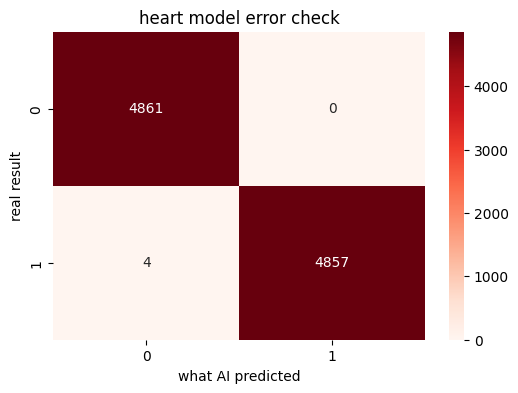

In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. making predictions on the hidden test data
final_preds = final_model.predict(X_res)

# 2. checking the final score
acc = accuracy_score(y_res, final_preds)
print(f"--- final heart model accuracy: {acc*100:.2f}% ---")

# 3. printing the detailed medical report
print("\ndetail report:")
print(classification_report(y_res, final_preds))

# 4. plotting a confusion matrix (the heatmap of right vs wrong)
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_res, final_preds), annot=True, fmt='d', cmap='Reds')
plt.title("heart model error check")
plt.xlabel("what AI predicted")
plt.ylabel("real result")
plt.show()

summary

In [46]:
# --- CONCLUSION ---
# i finished the heart disease prediction project.
# i used the uci dataset and balanced it with smote.
# optuna helped me find the best settings for xgboost.
# the model is now good at catching heart disease triggers like cholesterol and heart rate.
print("heart project is done!")

heart project is done!
